In [2]:
#importing  classical libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

#importing quantum libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector



In [3]:
#loading the dataset
df = pd.read_csv("corporateCreditRatingWithFinancialRatios.csv")
#selecting only most relevant features in finance
df = df[["Current Ratio", "Long-term Debt / Capital",'Net Profit Margin','ROE - Return On Equity','Binary Rating']]
#taking only 150 data points
df = df.head(150)
df

,Current Ratio,Long-term Debt / Capital,Net Profit Margin,ROE - Return On Equity,Binary Rating
0,1.1507,0.4551,8.3224,8.1724,1
1,1.1129,0.0072,13.5690,22.0354,1
2,1.9276,0.2924,2.1418,13.6376,1
3,0.8358,0.4708,9.0246,9.6412,1
4,1.2931,0.2644,0.6518,11.1256,1
...,...,...,...,...,...
145,2.1341,0.2922,3.9448,7.9447,0
146,1.5629,0.5694,10.8834,14.9511,1
147,0.9365,0.5274,0.9508,11.6270,1
148,0.9365,0.5274,0.9508,11.6270,1


In [4]:
#Splitting the dataset into features(X) and target(y)
feature_labels = list(df.columns[:5])
class_labels = [0,1]

X = np.array(df.drop("Binary Rating",axis=1))
y = np.array([df["Binary Rating"]])
M = 4 #Number of features

print("Feature Labels:",feature_labels)
print("Class Labels:",class_labels)

Feature Labels: ['Current Ratio', 'Long-term Debt / Capital', 'Net Profit Margin', 'ROE - Return On Equity', 'Binary Rating']
Class Labels: [0, 1]


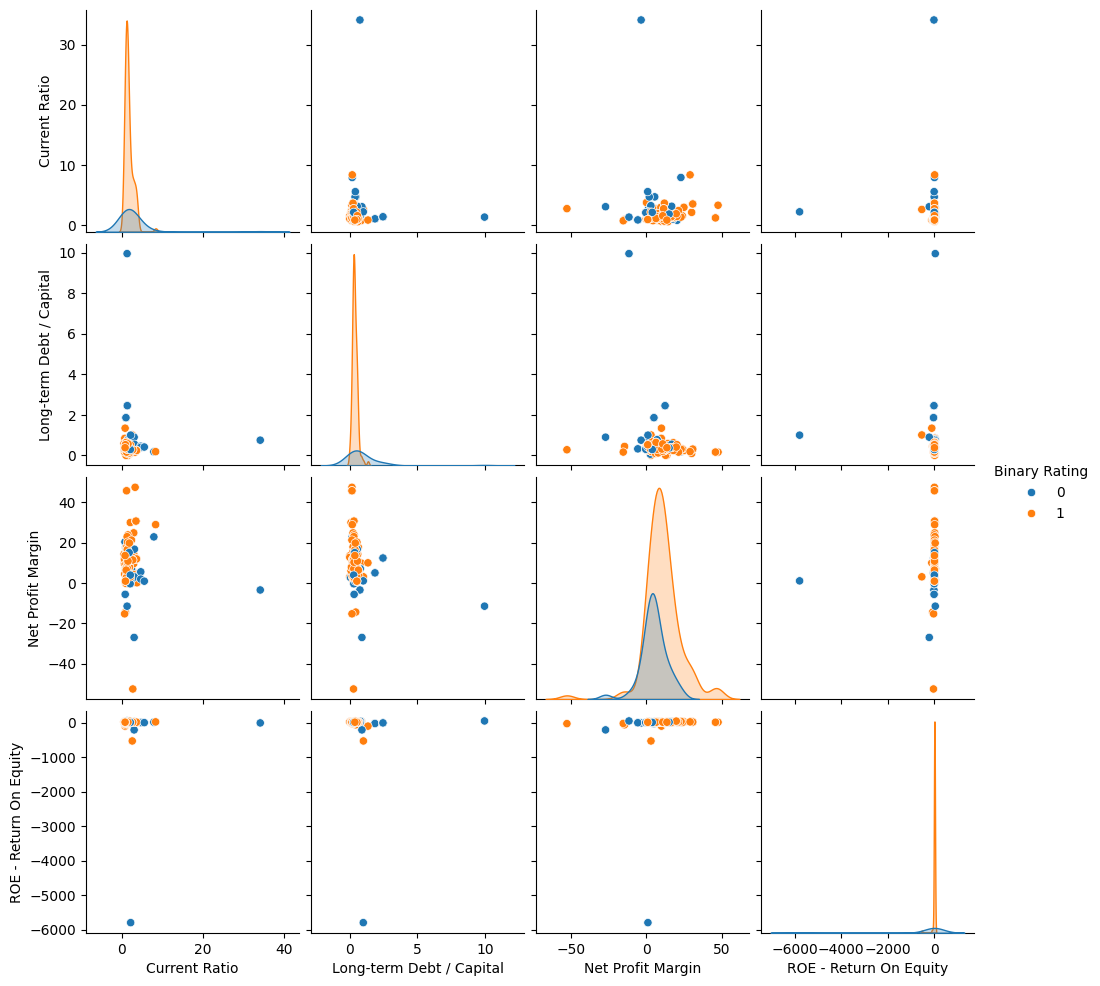

In [5]:
#pairplot of features
sns.pairplot(df,hue="Binary Rating")

In [5]:
#normalising the features(X)
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
X_normalized = scaler.fit_transform(X)

In [6]:
print(y.shape)
print(X.shape)

(1, 150)
(150, 4)


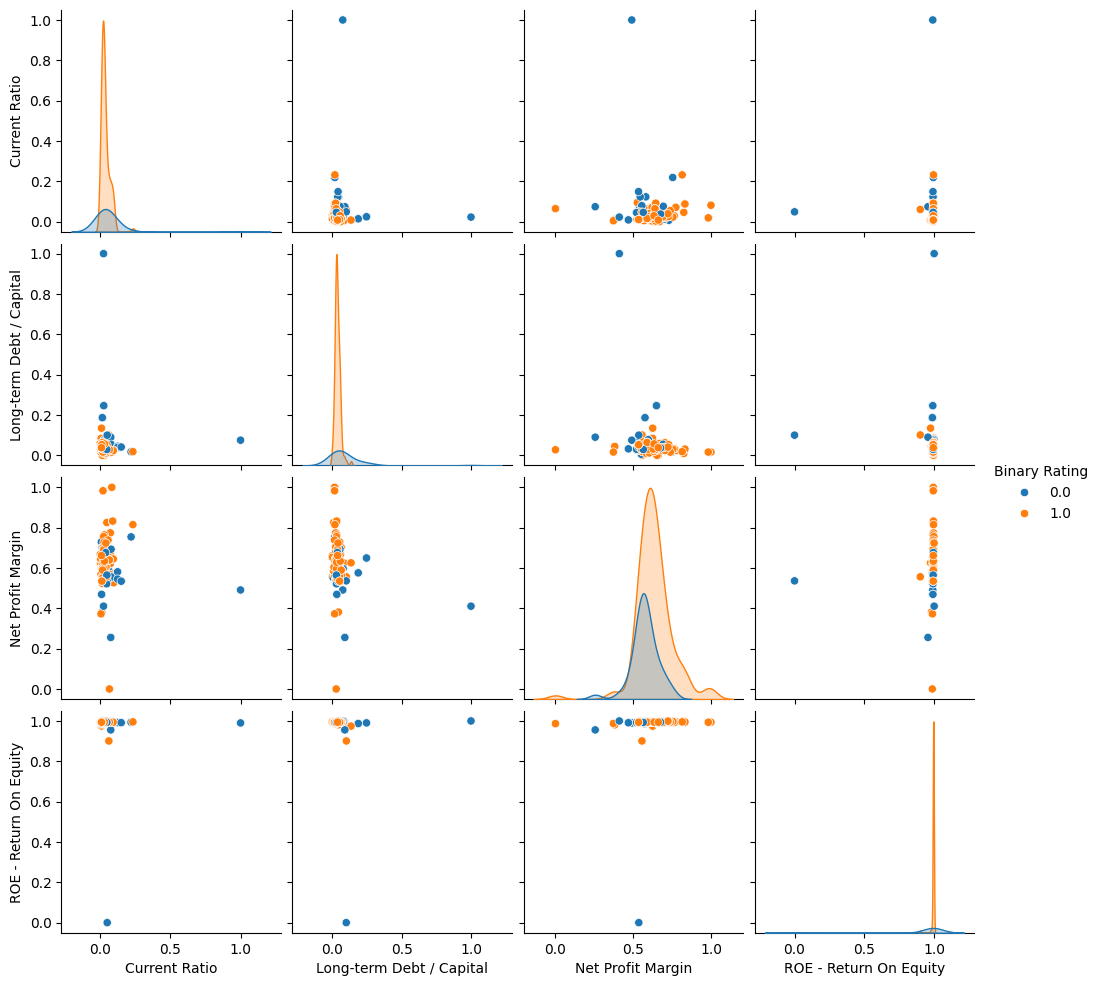

In [8]:
#pairplot of normalised features
df2 = pd.DataFrame(data=np.concatenate((X_normalized,y.T),axis=1),columns=feature_labels)
sns.pairplot(df2,hue="Binary Rating")

In [43]:
#splitting the dataset into training(100) and test(50) sets
N_train = 100
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y[0], train_size=N_train)

In [44]:
#Checking accuracy in classical knn with k=10
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.84


In [46]:
#selecting and encoding a random entry from the test set using amplitude encoding
test_index = int(np.random.rand()*len(X_test))
phi_test = X_test[test_index]

#We recursively create a normalized vector for each feature in the test data point and compute their tensor product to get a valid statevector
for i in range(M):
    phi_i = [np.sqrt(phi_test[i]),np.sqrt(1-phi_test[i])]
    if i==0:
        phi = phi_i
    else:
        phi = np.kron(phi_i,phi) #computing tensor product

print("Valid Statevector:",Statevector(phi).is_valid())

Valid Statevector: True


In [47]:
#Similarly we encode the whole training set along with its inidices as a single superposed state vector
N = int(np.ceil(np.log2(N_train)))
psi = np.zeros(2**(N+M))

for i in range(N_train):
    i_vec = np.zeros(2**N)
    i_vec[i] = 1 #encoding indices

    x = X_train[i,:]
    for j in range(M):
        temp = [np.sqrt(x[j]),np.sqrt(1-x[j])]
        if j==0:
            x_vec = temp
        else:
            x_vec = np.kron(temp,x_vec)
    psi_i = np.kron(x_vec,i_vec)
    psi +=psi_i #creating superposed state
psi /= np.sqrt(N_train)

print("Valid Statevector:",Statevector(psi).is_valid())

Valid Statevector: True


In [48]:
#defining registers for our quantum circuit
index_reg = QuantumRegister(N,"i")
train_reg = QuantumRegister(M,"train")
test_reg = QuantumRegister(M,"test")
s = QuantumRegister(1,"similarity")

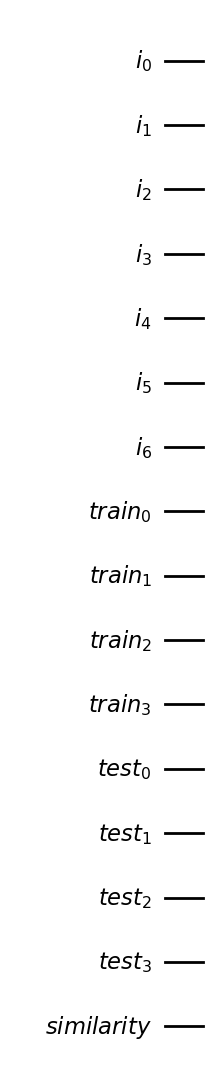

In [49]:
#creating a quantum circuit and adding registers
qknn = QuantumCircuit()

qknn.add_register(index_reg) #register for storing indices of train dataset
qknn.add_register(train_reg) #register for storing feature values of training datapoint
qknn.add_register(test_reg) #register for storing feature values of test datapoint
qknn.add_register(s) #register for storing our similarity score

qknn.draw('mpl')

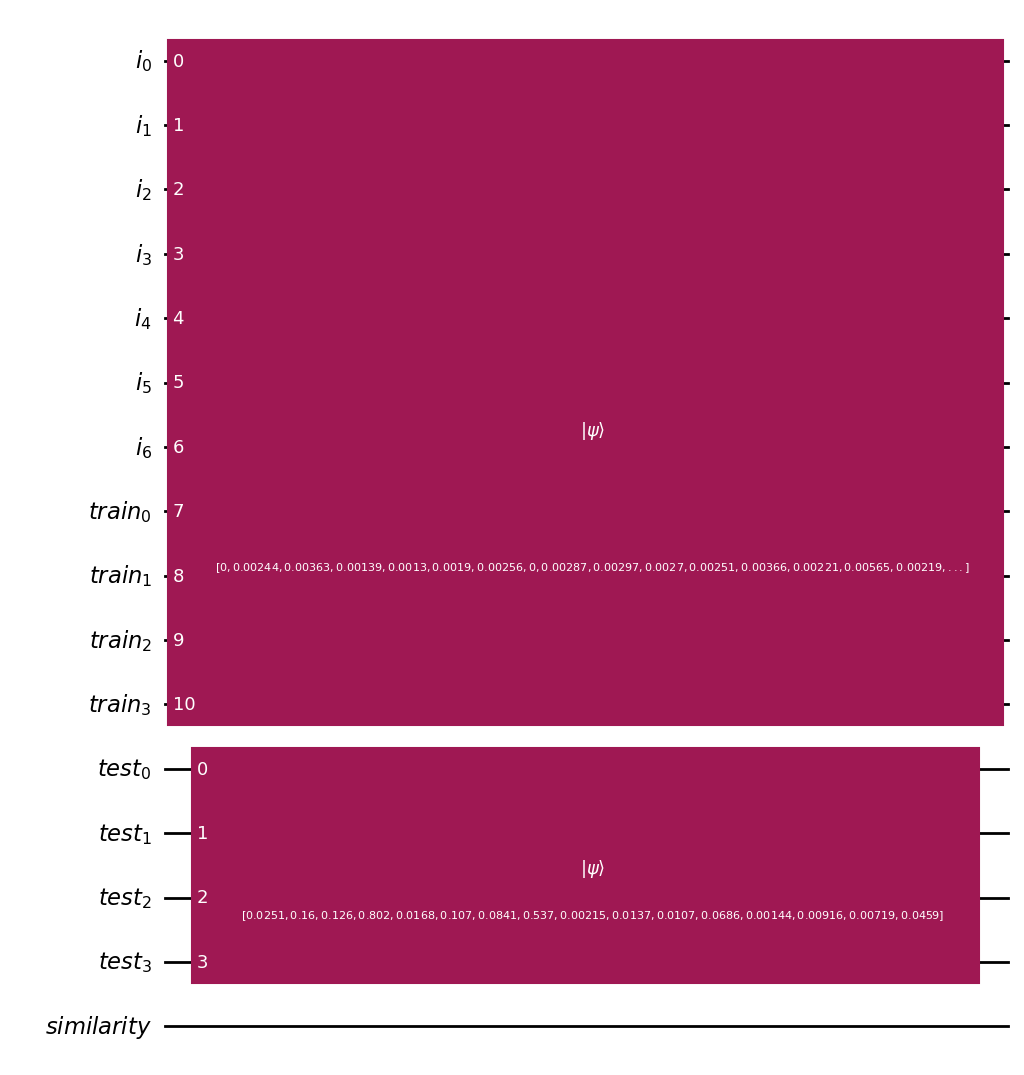

In [50]:
#initialising the state vectors to their respective registers
qknn.initialize(psi,index_reg[:]+train_reg[:])
qknn.initialize(phi,test_reg)
qknn.draw('mpl',fold=-1)

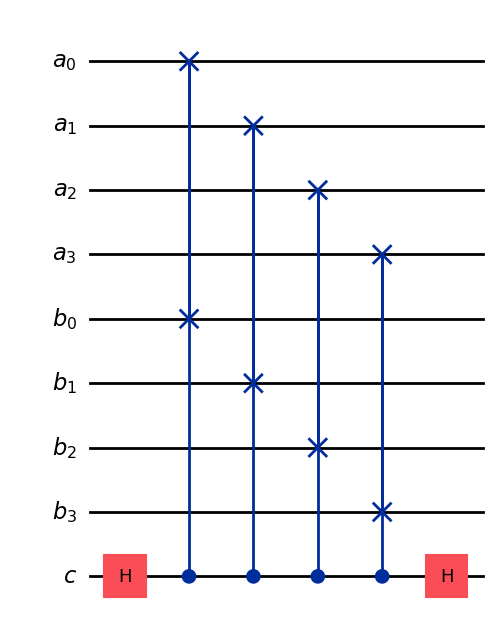

In [51]:
#constructing our swap test circuit
def swap_test(n):
    a = QuantumRegister(n,'a')
    b = QuantumRegister(n,'b')
    c = QuantumRegister(1,'c')

    qc = QuantumCircuit(name= 'Swap \n Test')
    qc.add_register(a)
    qc.add_register(b)
    qc.add_register(c)

    qc.h(c)
    for i in range(n):
        qc.cswap(c,a[i],b[i])
    qc.h(c)

    return qc

test = swap_test(M)
test.draw('mpl')


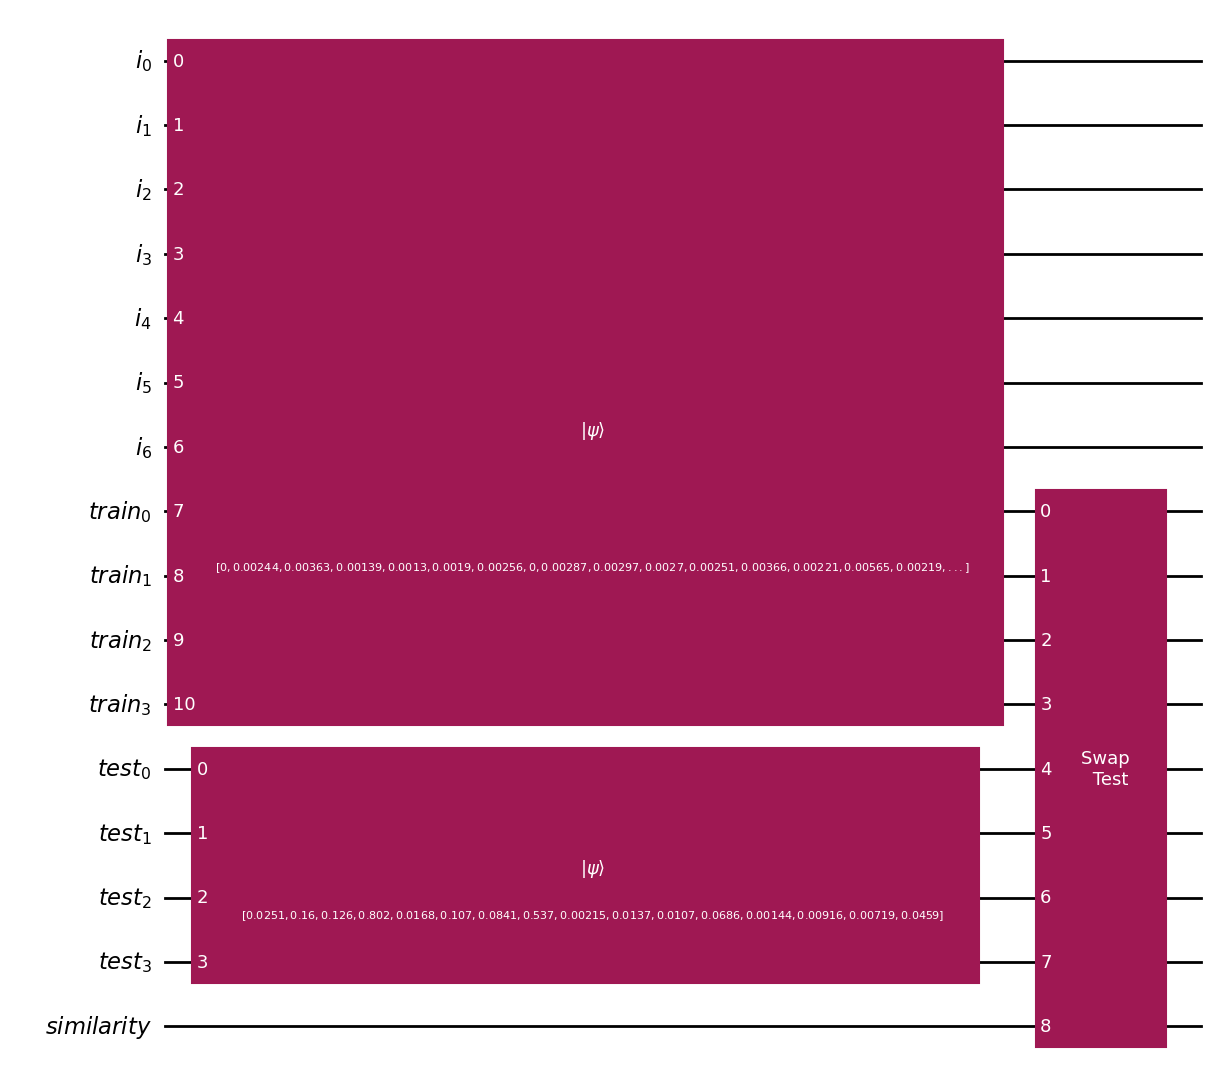

In [52]:
#appending the swap test circuit to our main quantum circuit
qknn.append(swap_test(M),train_reg[:]+test_reg[:]+[s[0]])
qknn.draw('mpl')

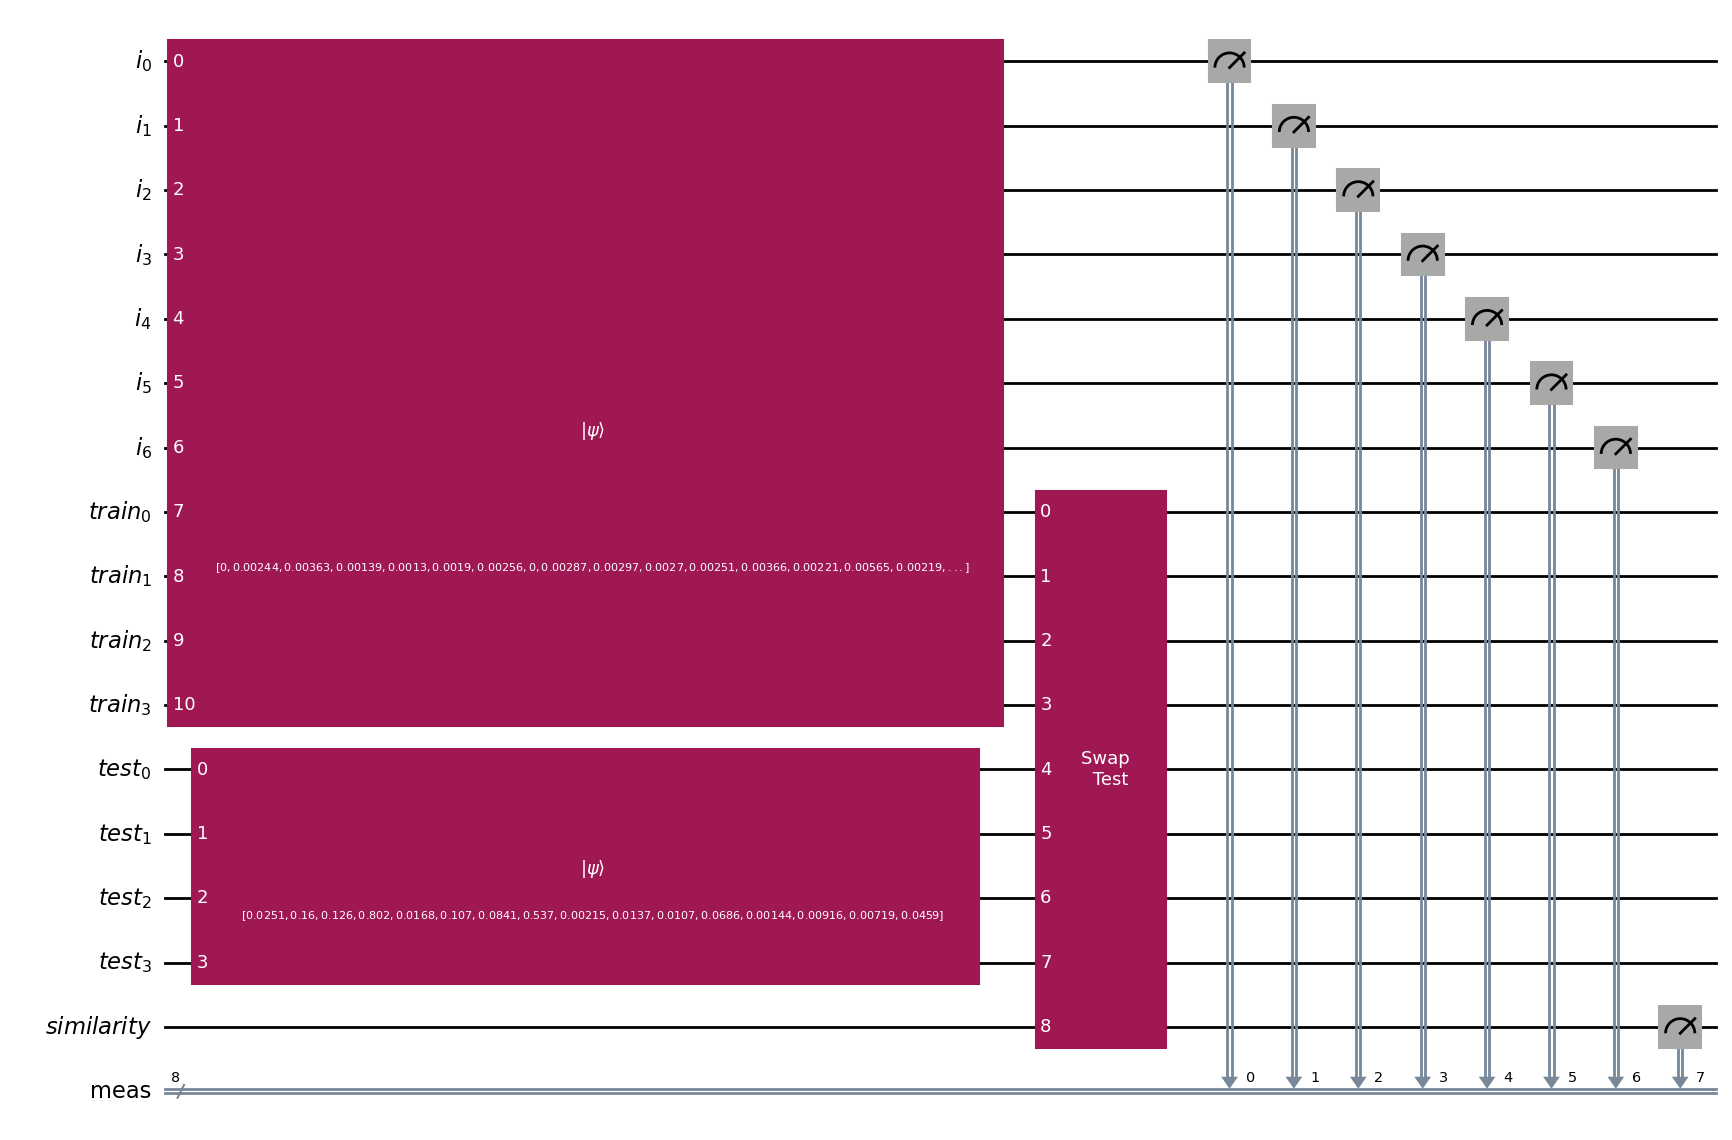

In [53]:
#defining and adding classical register
meas_reg = ClassicalRegister(N+1,'meas')
qknn.add_register(meas_reg)

#measuring the index and similarity qubits
qknn.measure(index_reg[:]+[s[0]],meas_reg)

qknn.draw('mpl',fold=-1)

In [54]:
#running the circuit on 'qasm_simulator' backend
backend = Aer.get_backend('qasm_simulator')

new_circuit = transpile(qknn,backend)
counts_knn = backend.run(new_circuit,shots=15000).result().get_counts()

In [55]:
#gathering count results
results_arr = np.zeros((N_train,3))
for count in counts_knn:
    i_dec = int(count[1:],2) #index value
    phase = int(count[0]) #similarity value
    if phase == 0:
        results_arr[i_dec,0]+=counts_knn[count]
    else:
        results_arr[i_dec,1]+=counts_knn[count]  

In [56]:
#calculating the similarity score
for i in range(N_train):
    prob_1 = results_arr[i,1]/(results_arr[i,0]+results_arr[i,1])
    similarity = 1-2*prob_1
    results_arr[i,2] = similarity

In [57]:
#predicting the label of the test data point by taking the majority label from the 10 most similar training data points
k=10
k_min_dist_arr = results_arr[:,2].argsort()[::-1][:k]

y_pred = mode(y_train[k_min_dist_arr])
y_exp = y_test[test_index]

print('Predicted:',y_pred)
print('Actual:',y_exp)

Predicted: 1
Actual: 1


In [105]:
#repeating this entire procedure for all test data points and calculating the model accuracy
def qknn_module(test_index, psi, k=10):
    phi_test = X_test[test_index]

    for i in range(M):
        phi_i = [np.sqrt(phi_test[i]),np.sqrt(1-phi_test[i])]
        if i==0:
            phi = phi_i
        else:
            phi = np.kron(phi_i,phi)

    qknn = QuantumCircuit()
    qknn.add_register(index_reg)
    qknn.add_register(train_reg)
    qknn.add_register(test_reg)
    qknn.add_register(s)

    qknn.initialize(psi,index_reg[:]+train_reg[:])
    qknn.initialize(phi,test_reg)

    qknn.append(swap_test(M),train_reg[:]+test_reg[:]+[s[0]])

    qknn.add_register(meas_reg)
    qknn.measure(index_reg[:]+[s[0]],meas_reg)

    backend = Aer.get_backend('qasm_simulator')
    new_circuit = transpile(qknn,backend)
    counts_knn = backend.run(new_circuit,shots=15000).result().get_counts()

    results_arr = np.zeros((N_train,3))
    for count in counts_knn:
        i_dec = int(count[1:],2)
        phase = int(count[0])
        if phase == 0:
            results_arr[i_dec,0]+=counts_knn[count]
        else:
            results_arr[i_dec,1]+=counts_knn[count]
            
    for i in range(N_train):
        prob_1 = results_arr[i,1]/(results_arr[i,0]+results_arr[i,1])
        similarity = 1-2*prob_1
        results_arr[i,2] = similarity   

    k_min_dist_arr = results_arr[:,2].argsort()[::-1][:k]
    y_pred = mode(y_train[k_min_dist_arr])
    y_exp = y_test[test_index]

    return y_pred, y_exp

y_pred_arr = []
y_exp_arr = []

for i in range(len(X_test)):
    y_pred, y_exp = qknn_module(i,psi)
    y_pred_arr.append(y_pred)
    y_exp_arr.append(y_exp)

t=0
f=0

for i in range(len(X_test)):
    if y_pred_arr[i]==y_exp_arr[i]:
        t+=1
    else:
        f+=1

#calculating model accuracy
print("Accuracy of the model:",t/(t+f) *100) 

Accuracy of the model: 80.0
